In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Environment import Environment, ContextConfig
from ContextNode import ContextNode
from TS import TS
from UCB import UCB
from Solver import Solver

In [2]:
env = Environment()
solver = Solver(env)
optimal_configurations, optimal_rewards = solver.find_optimal()

"""
Should be:
UserType 0:   2, 0, 1, 2, 3  -> FF (class: 0) + FV (class: 1)
UserType 1:   3, 1, 3, 0, 2  -> VF (class: 2)
UserType 2:   0, 3, 1, 2, 0  -> VV (class: 3)
"""

print("OPTIMAL CONFIGURATION")
print(optimal_configurations)
print("OPTIMAL A-PRIORI REWARD")
print(optimal_rewards)

OPTIMAL CONFIGURATION
[[2 0 1 2 3]
 [3 1 3 0 2]
 [0 3 1 2 0]]
OPTIMAL A-PRIORI REWARD
[7.81830836 7.17302757 7.42556207]


In [3]:
runs = 20
T = 100
split_step = 14

ucb_results = []
ts_results = []
optimal_results = []

ucb_track = {
    '1x': 0,
    '1F': 0,
    '1T': 0,
    '2x': 0,
    '2F': 0,
    '2T': 0
}
ts_track = {
    '1x': 0,
    '1F': 0,
    '1T': 0,
    '2x': 0,
    '2F': 0,
    '2T': 0
}

In [4]:
for r in range(runs):
    env.clear_history()

    ucb_rounds = []
    ts_rounds = []
    optimal_rounds = []
    learners = []

    ucb_root = ContextNode(env, UCB, feature_1=None, feature_2=None)
    ts_root = ContextNode(env, TS, feature_1=None, feature_2=None)

    ucb_splits = []
    ts_splits = []

    optimal_ctx_configs = [ContextConfig(config, [user_type, user_type + 1]) if user_type == 0
                           else ContextConfig(config, [user_type + 1])
                           for user_type, config in enumerate(optimal_configurations)]

    print("\n########## RUN", r+1, "\n")

    for i in range(T):
        seed = np.random.randint(1, 2 ** 30)

        ucb_leaves = ucb_root.get_leaves()
        if i > 0 and i % split_step == 0:
            for leaf in ucb_leaves:
                if leaf.split():
                    ucb_splits.append(i)
                    if leaf.feature_1 is None and leaf.feature_2 is None:
                        if leaf.left.feature_1 is not None:
                            ucb_track['1x'] += 1
                        else:
                            ucb_track['2x'] += 1
                    elif leaf.feature_1 is not None:
                        if leaf.feature_1 is False:
                            ucb_track['1F'] += 1
                        else:
                            ucb_track['1T'] += 1
                    elif leaf.feature_2 is not None:
                        if leaf.feature_2 is False:
                            ucb_track['2F'] += 1
                        else:
                            ucb_track['2T'] += 1
            ucb_leaves = ucb_root.get_leaves()
        ucb_learners = [leaf.learner for leaf in ucb_leaves]
        ucb_ctx_configs = [ContextConfig(ucb.pull(), ucb.agg_classes) for ucb in ucb_learners]
        ucb_round_data = env.round(ucb_ctx_configs, learner_class=UCB, seed=seed)
        ucb_rounds.append(ucb_round_data)
        for ucb_learner in ucb_learners:
            ucb_learner.update(ucb_round_data)

        ts_leaves = ts_root.get_leaves()
        if i > 0 and i % split_step == 0:
            for leaf in ts_leaves:
                if leaf.split():
                    ts_splits.append(i)
                    if leaf.feature_1 is None and leaf.feature_2 is None:
                        if leaf.left.feature_1 is not None:
                            ts_track['1x'] += 1
                        else:
                            ts_track['2x'] += 1
                    elif leaf.feature_1 is not None:
                        if leaf.feature_1 is False:
                            ts_track['1F'] += 1
                        else:
                            ts_track['1T'] += 1
                    elif leaf.feature_2 is not None:
                        if leaf.feature_2 is False:
                            ts_track['2F'] += 1
                        else:
                            ts_track['2T'] += 1
            ts_leaves = ts_root.get_leaves()
        ts_learners = [leaf.learner for leaf in ts_leaves]
        ts_ctx_configs = [ContextConfig(ts.pull(), ts.agg_classes) for ts in ts_learners]
        ts_round_data = env.round(ts_ctx_configs, learner_class=TS, seed=seed)
        ts_rounds.append(ts_round_data)
        for ts_learner in ts_learners:
            ts_learner.update(ts_round_data)

        optimal_round_data = env.round(optimal_ctx_configs, seed=seed)
        optimal_rounds.append(optimal_round_data)

    ucb_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])
    ts_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])
    optimal_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])

    for user_type in range(env.n_user_types):
        for i in range(T):
            ucb_rewards[user_type][i] = ucb_rounds[i].rewards[user_type]
            ts_rewards[user_type][i] = ts_rounds[i].rewards[user_type]
            optimal_rewards[user_type][i] = optimal_rounds[i].rewards[user_type]

    print("--------------------UCB---------------------")
    print("AVERAGE REWARD:")
    print("\t", np.average(ucb_rewards))
    print("AVERAGE REGRET:")
    print("\t", np.average(optimal_rewards - ucb_rewards))

    print("--------------------TS----------------------")
    print("AVERAGE REWARD:")
    print("\t", np.average(ts_rewards))
    print("AVERAGE REGRET:")
    print("\t", np.average(optimal_rewards - ts_rewards))

    ucb_results.append(ucb_rewards)
    ts_results.append(ts_rewards)
    optimal_results.append(optimal_rewards)


########## RUN 1 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.5422498537536384
AVERAGE REGRET:
	 0.39766500771849433
--------------------TS----------------------
AVERAGE REWARD:
	 3.7607519130869362
AVERAGE REGRET:
	 0.17916294838519684

########## RUN 2 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.550685219100355
AVERAGE REGRET:
	 0.3957430759499229
--------------------TS----------------------
AVERAGE REWARD:
	 3.7604716044877917
AVERAGE REGRET:
	 0.185956690562486

########## RUN 3 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.5742622885402904
AVERAGE REGRET:
	 0.38776568058891586
--------------------TS----------------------
AVERAGE REWARD:
	 3.7745341703737783
AVERAGE REGRET:
	 0.18749379875542815

########## RUN 4 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.5750546607225084
AVERAGE REGRET:
	 0.38589128964251124
--------------------TS----------------------
AVERAGE REWARD:
	 3.760829575179205
AVE

In [5]:
ucb_results = np.array(ucb_results)
ts_results = np.array(ts_results)
optimal_results = np.array(optimal_results)

rounds = list(range(T))
xticks = np.arange(0, 100, 14)

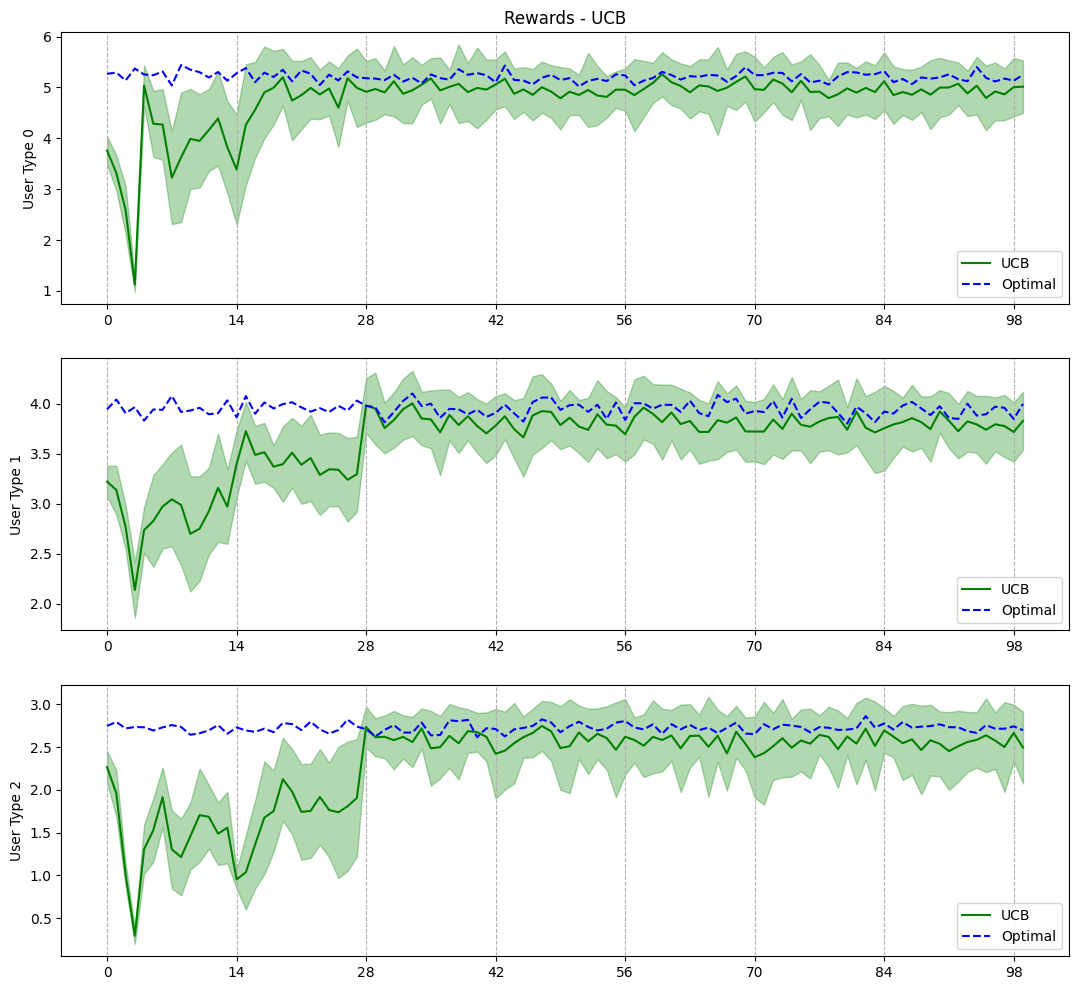

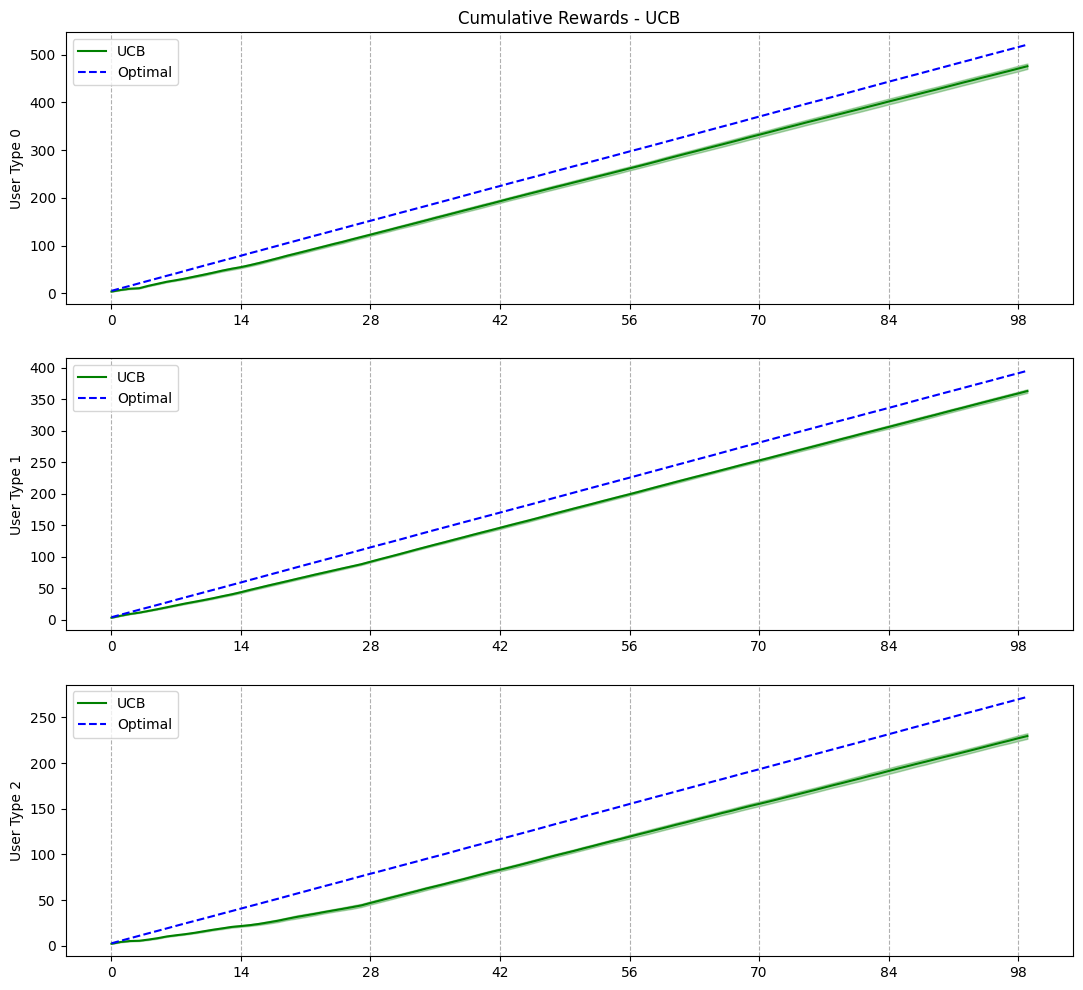

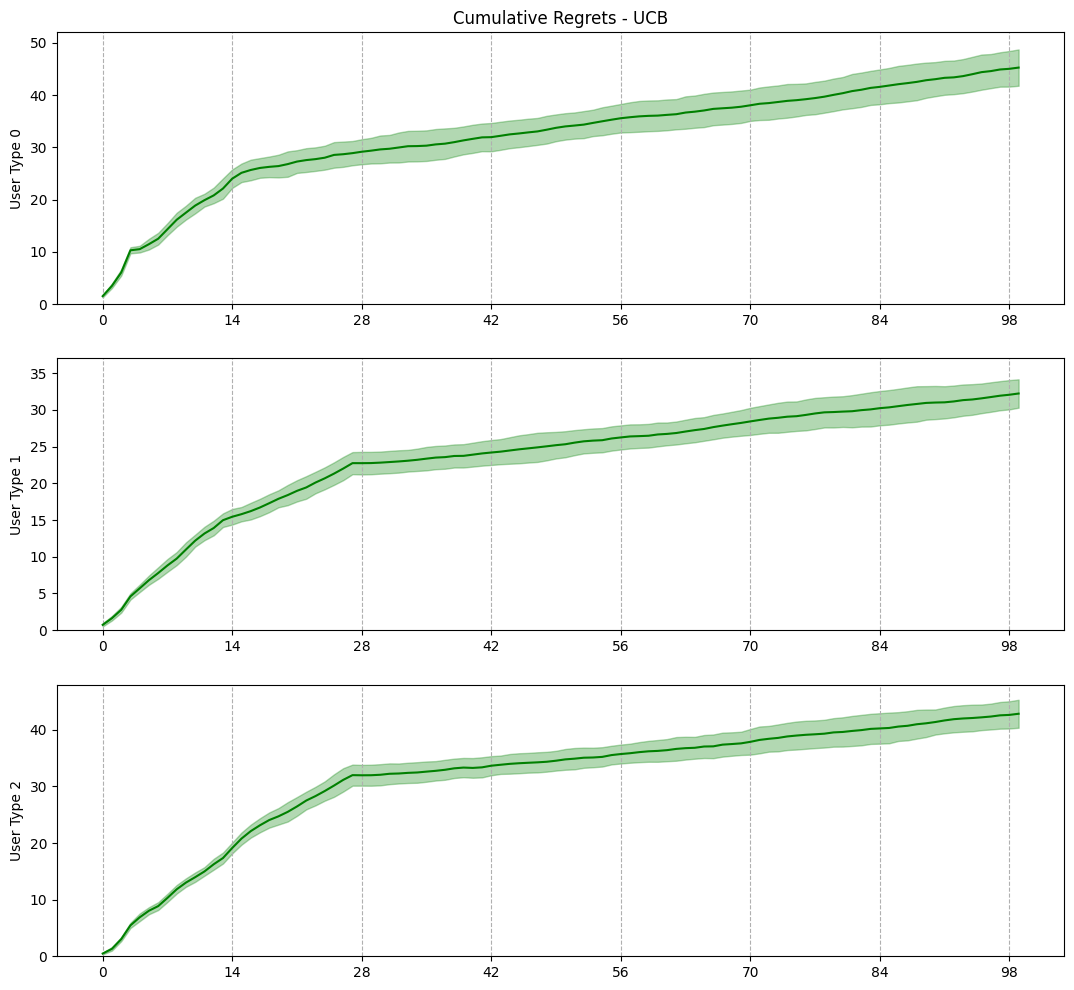

In [17]:
for user_type in range(env.n_user_types):

    # REWARDS

    fig = plt.figure(0, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Rewards - UCB')
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(ucb_results, axis=0)[user_type]
    std = np.std(ucb_results, axis=0)[user_type]
    optimal = np.average(optimal_results, axis=0)[user_type]
    ax.plot(means, 'g', label="UCB")
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='green')
    ax.plot(optimal, 'b--', label="Optimal")
    plt.legend()

    # CUMULATIVE REWARDS

    fig = plt.figure(1, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Cumulative Rewards - UCB')
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(np.cumsum(ucb_results, axis=2), axis=0)[user_type]
    std = np.std(np.cumsum(ucb_results, axis=2), axis=0)[user_type]
    optimal = np.average(np.cumsum(optimal_results, axis=2), axis=0)[user_type]
    ax.plot(means, 'g', label="UCB")
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='green')
    ax.plot(optimal, 'b--', label="Optimal")
    plt.legend()

    # CUMULATIVE REGRETS

    fig = plt.figure(2, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Cumulative Regrets - UCB')
        plt.ylim(0, 52)
    elif user_type == 1:
        plt.ylim(0, 37)
    else:
        plt.ylim(0, 48)
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(np.cumsum(optimal_results - ucb_results, axis=2), axis=0)[user_type]
    std = np.std(np.cumsum(optimal_results - ucb_results, axis=2), axis=0)[user_type]
    ax.plot(means, 'g')
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='green')

plt.show()

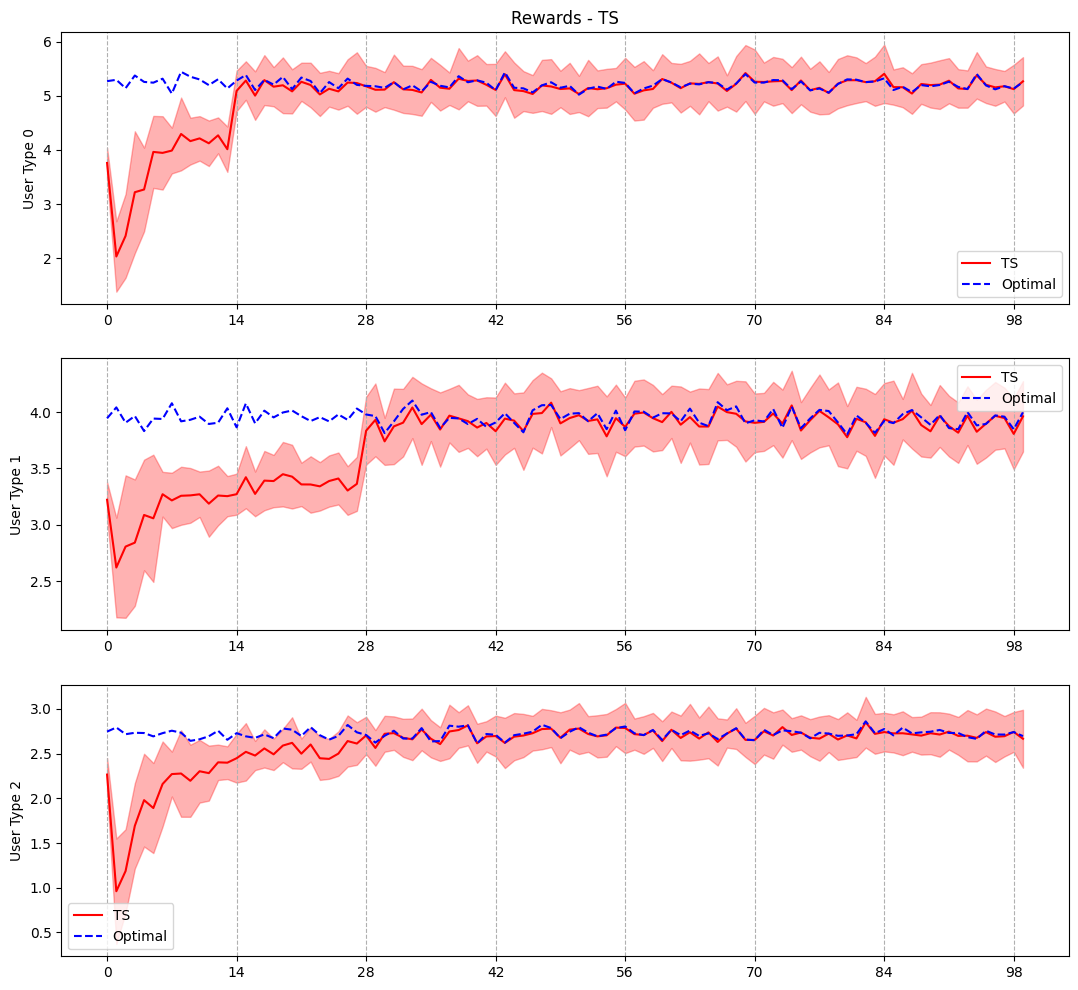

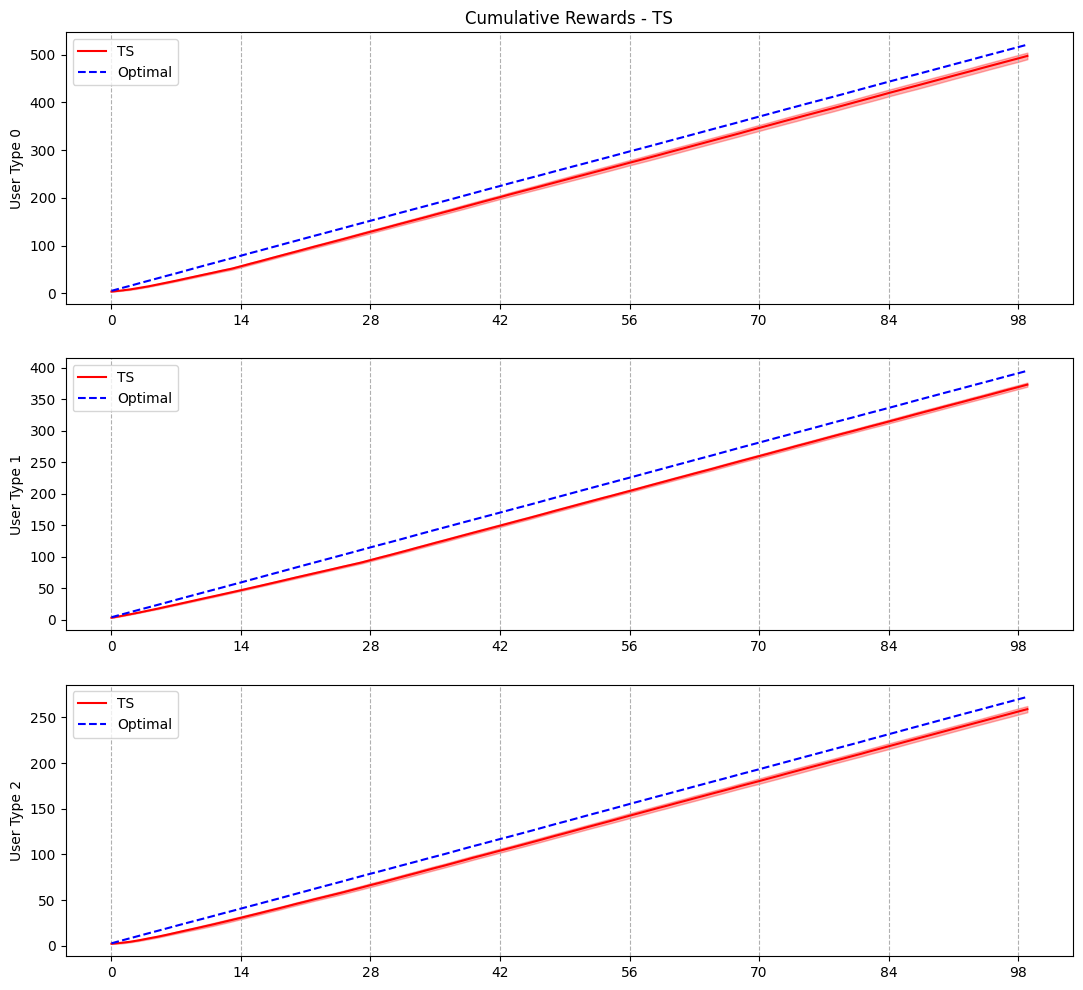

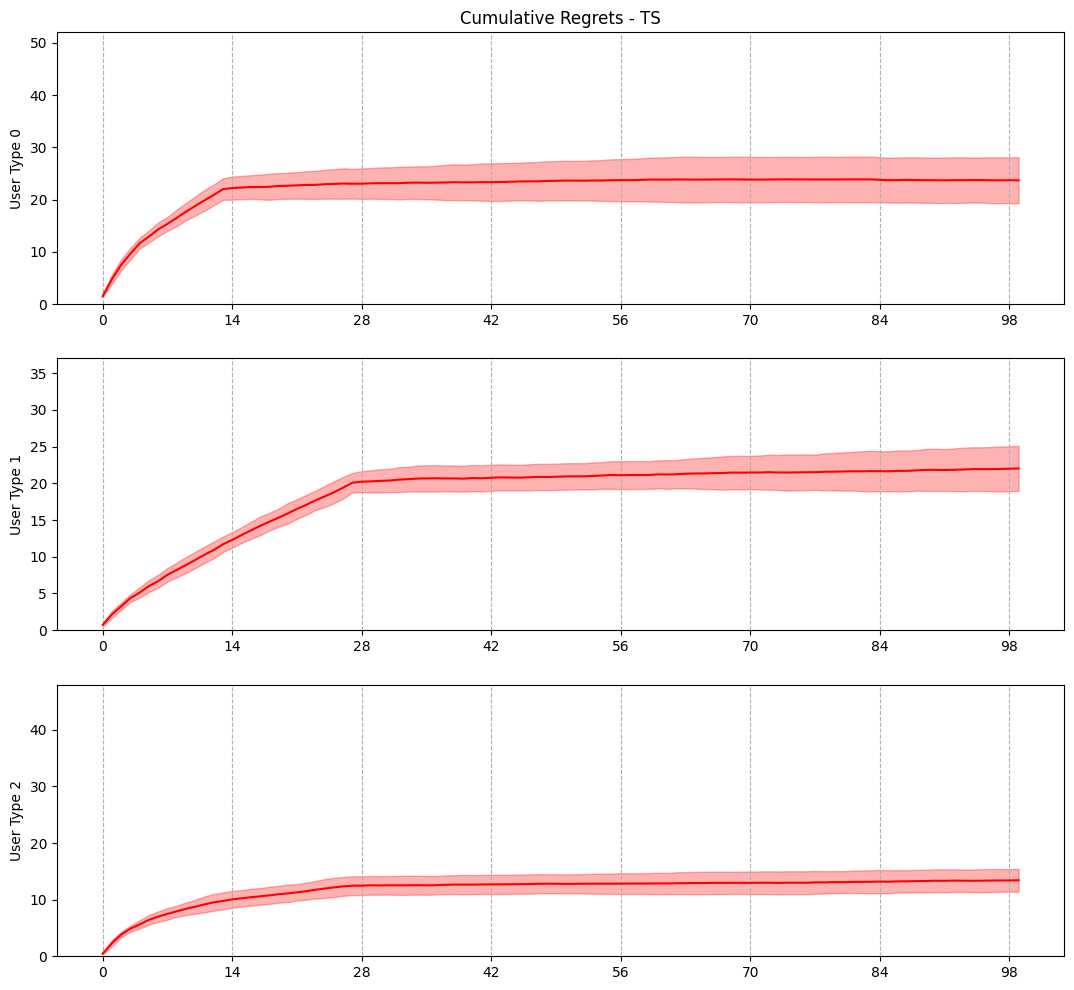

In [18]:
for user_type in range(env.n_user_types):

    # REWARDS

    fig = plt.figure(0, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Rewards - TS')
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(ts_results, axis=0)[user_type]
    std = np.std(ts_results, axis=0)[user_type]
    optimal = np.average(optimal_results, axis=0)[user_type]
    ax.plot(means, 'r', label="TS")
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='red')
    ax.plot(optimal, 'b--', label="Optimal")
    plt.legend()

    # CUMULATIVE REWARDS

    fig = plt.figure(1, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Cumulative Rewards - TS')
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(np.cumsum(ts_results, axis=2), axis=0)[user_type]
    std = np.std(np.cumsum(ts_results, axis=2), axis=0)[user_type]
    optimal = np.average(np.cumsum(optimal_results, axis=2), axis=0)[user_type]
    ax.plot(means, 'r', label="TS")
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='red')
    ax.plot(optimal, 'b--', label="Optimal")
    plt.legend()

    # CUMULATIVE REGRETS

    fig = plt.figure(2, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    if user_type == 0:
        plt.title(f'Cumulative Regrets - TS')
        plt.ylim(0, 52)
    elif user_type == 1:
        plt.ylim(0, 37)
    else:
        plt.ylim(0, 48)
    plt.ylabel(f'User Type {user_type}')
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.grid(which='major', axis='x', linestyle='--')

    means = np.average(np.cumsum(optimal_results - ts_results, axis=2), axis=0)[user_type]
    std = np.std(np.cumsum(optimal_results - ts_results, axis=2), axis=0)[user_type]
    ax.plot(means, 'r')
    ax.fill_between(rounds, means-std, means+std, alpha=0.3, color='red')

plt.show()

In [11]:
ucb_track

{'1x': 20, '1F': 15, '1T': 20, '2x': 0, '2F': 0, '2T': 0}

In [9]:
ts_track

{'1x': 20, '1F': 19, '1T': 20, '2x': 0, '2F': 0, '2T': 0}

In [14]:
(15+19)/40

0.85

In [13]:
19/20

0.95